# Cross-Validation Gone Wrong - thresholdout

*This notebook first appeared as a [blog post](//betatim.github.io/posts/cross-validation-gone-wrong) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Every time you want to use machine learning to solve a challenge you face a problem: Choosing the input features, classifier type, ... and then estimating your new model's performance. Simultaneously it is one of the most important steps as the difference in performance can be quite different for different models, so optimising your choices matters.

A universially used technique to help with this task, called model selection, is cross-validation. Using cross-validation is an excellent idea, but as with everything there are some traps waiting for you.

This post is about some of traps and how to avoid them.

As usual, first a few imports:

In [1]:
%matplotlib inline

In [2]:
import numpy as np

from scipy.stats import sem

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline


np.random.seed(6450345)

## Feature Selection

Often selecting which features/variables to include in your model is part of the model selection step. Let's try it.

One strategy to select a subset of features is to evaluate how correlated each one is with the class labels and then choose the $N$ features with the largest correlation.

Let's create a dataset where the class labels are chosen at random:

In [3]:
def make_data(N=1000, n_vars=10,
              n_classes=2):
    X = np.random.normal(size=(N,n_vars))
    y = np.random.choice(n_classes, N)
    
    return X, y

What does the correlation matrix between the different features and the class labels look like:

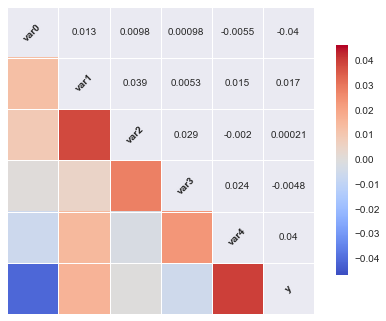

In [4]:
X,y = make_data(n_vars=5)

sns.corrplot(np.c_[X, y],
             names=["var%i"%n for n in range(X.shape[1])]+['y'])

As you can see the correlations are not huge, but some variables have a higher correlation than others.

Let's select the 20 features with the largest correlation and then use cross-validation to evaluate the performance of our choice.

In [5]:
X,y = make_data(N=10000, n_vars=10000)
Xp,yp = make_data(N=10000, n_vars=10000)

Xp_train,Xp_test, yp_train,yp_test = train_test_split(Xp, yp, test_size=0.5)

scores = []
scores2 = []
train_scores = []
fresh_scores = []
for n_features in range(1, 20):
    print n_features,
    select = SelectKBest(f_regression, k=n_features)
    X_slim = select.fit_transform(X,y)
    
    Xp_slim = select.transform(Xp_train)

    clf = GradientBoostingClassifier()

    cv_scores = cross_val_score(clf, X_slim,y, cv=3, n_jobs=8)
    scores.append((np.mean(cv_scores), sem(cv_scores)))
    
    clf.fit(X_slim, y)
    
    train_scores.append(clf.score(X_slim, y))
    fresh_scores.append(clf.score(Xp_slim, yp_train))
    
    clf2 = make_pipeline(SelectKBest(f_regression, k=n_features),
                         GradientBoostingClassifier())

    cv_scores = cross_val_score(clf2, X,y, cv=2)

    scores2.append((np.mean(cv_scores), sem(cv_scores)))

    print (np.mean(cv_scores), sem(cv_scores))

1 (0.49340129973605201, 0.0064986802599472085)
2 (0.49960073998402965, 0.003699920147996832)
3 (0.4962998798519952, 0.00060074002402960003)
4 (0.49010191960407679, 0.0095980203839208227)
5 (0.49340189973607601, 0.0094986803799472219)
6 (0.49200205968008237, 0.010298400411936054)
7 (0.49580161983206483, 0.0080991603239664294)
8 (0.49470031978801277, 0.0015989400639575824)
9 (0.49609991984399682, 0.00040078001603119362)
10 (0.49130091965203682, 0.0045982601839304185)
11 (0.49600089984003598, 0.0044992001799680215)
12 (0.49410091976403681, 0.0045988201839528009)
13 (0.49430007977200319, 0.00039886001595440534)
14 (0.48859997954399914, 0.00010228000409120973)
15 (0.49000041960001683, 0.0020980000839199986)
16 (0.4916004196640168, 0.002098320083932792)
17 (0.49430051977202083, 0.002598860103954409)
18 (0.49500061980002474, 0.0030990001239599991)
19 (0.49390127975605125, 0.0063987802559512244)


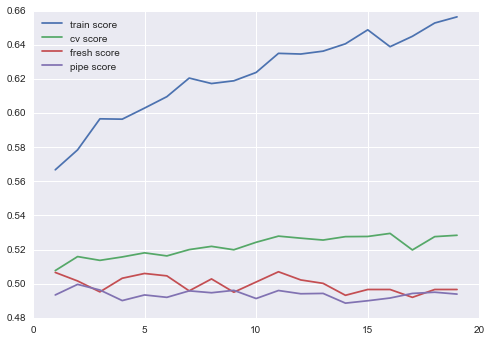

In [6]:
plt.plot(range(1, len(scores)+1), train_scores, label='train score')
plt.plot(range(1, len(scores)+1), [s[0] for s in scores], label='cv score')
plt.plot(range(1, len(scores)+1), fresh_scores, label='fresh score')
plt.plot(range(1, len(scores)+1), [s[0] for s in scores2], label='pipe score')


plt.legend(loc='best')
#plt.ylim([0.45, 0.75])

In [ ]:
def make_data(N=1000, n_vars=10,
              n_classes=2):
    X = np.random.normal(size=(N,n_vars))
    y = np.random.choice(n_classes, N)
    
    return X, y

n_features = 1
X,y = make_data(N=10000, n_vars=10000)
clf2 = make_pipeline(SelectKBest(f_regression, k=n_features),
                     GradientBoostingClassifier())

cv_scores = cross_val_score(clf2, X,y, cv=2, n_jobs=8)

## Huzzah!

Machine learning is magic! Using features which have no bearing what so ever on the class labels we managed to predict the correct class in about 60% of cases, 10% better than what would be expected from random guessing.

Can you spot where we cheated?

## Doing it the Right Way

There is no way to beat logic. None of the features contains any information about the class labels, afterall they were choosen at random. So how did we manage to outperform guessing? We cheated when we selected the features we use to train our classifier. We used the full data to find
the two features with the highest correlation with the labels and used those.

If you want cross validation to give you an unbiased estimated of your true performance any and all your choices about features, hyper-parameters and the like have to be performed within the cross validation loop.

Here is how to do it right:

In [6]:
from sklearn.pipeline import make_pipeline

clf = make_pipeline(SelectKBest(f_regression, k=20),
                    GradientBoostingClassifier())

scores = cross_val_score(clf, X, y, cv=5)

print "Scores on each subset:"
print scores
avg = (100*np.mean(scores), 100*np.std(scores)/np.sqrt(scores.shape[0]))
print "Average score and uncertainty: (%.2f +- %.3f)%%"%avg

Scores on each subset:
[ 0.485   0.5     0.5375  0.5175  0.5075]
Average score and uncertainty: (50.95 +- 0.785)%


Once you include your choice of the 20 best variables in your cross validation pipeline, everything is back to normal.

No one, not even super smart ensembles of decision trees can perform miracles. If your labels are unrelated to the features, you might as well just guess.

## Take Home Message

Choosing your input features is just one of the many choices you have to make when building your machine-learning application. Remember to make all decisions during the cross validation, otherwise you are in for a rude awakening when your model is confronted with unseen data for the first time.

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)